<a href="https://colab.research.google.com/github/BzGEO/hls-composite-bdec/blob/main/scripts/bdec_hls_composite_data_access__tile_15qya_colab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This is a custmization of the Jupyter Notebook developed by Dr. Madhu Sridhar of NASA OSDI, for the extraction and compositing of
# Harmonized Landsat Sentinel-2 (HLS) data, and the generation of vegetation indices from said data. The original notebook can be found here:
# https://github.com/NASA-IMPACT/hls-composite-bdec/blob/main/scripts/bdec-hls-composite-data-access-notebook-example.ipynb.

In [2]:
# Install required packages
!pip install rioxarray
!pip install datashader
!pip install pandas
!pip install xarray
!pip install dask
!pip install hvplot
!pip install matplotlib
!pip install numpy
!pip install boto3
!pip install jupyter_bokeh


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.12.0
    Uninstalling xarray-2025.12.0:
      Successfully uninstalled xarray-2025.12.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.6/180.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6

In [3]:
import pandas as pd
import rioxarray
import os
import xarray as xr
import dask
from datetime import datetime
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import boto3
import jupyter_bokeh

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# other requirements
# * hvplot requires datashader package

In [ ]:
## This script provides some examples of accessing and processing data with cloud native methods
# 1. Reads composite data from the S3 bucket using xarray's lazy loading
# 2. Provides instructions on bulk data download from S3 bucket to local machine
# 3. Plots composited bands
# 4. Calcualtes NDVI and visualizes results on an interactive plot
# 5. Plots true color composited image generated from R,G,B bands
# 6. Plots a time history of composited data for a pixel

# NOTES
# 1. If no HLS data is found for the 30 or 10 day interval, an empty file called 'No granules found' included
# 2. scaling factor for composited raster is 0.0001, but not reflected in the metadata yet
# 3. No-data value is set to -9999 in the raster, but metadata says scale_factor=1 (NEED TO BE CORRECTED)
# 4. Additional layers available in the composited granule: std dev, Validcount, and Day of Year (DOY)

# Useful links
# NASA Openscapes tutorials: https://github.com/NASA-Openscapes/2021-Cloud-Hackathon/tree/main/tutorials

In [ ]:
# # Example aws commands to bulk download data to local machine

# # List the contents of the bucket
# !aws s3 ls s3://{bucket_name} --no-sign-request

# # create prefix and list contents
# prefix = f'test-composite-{composite_alg}/{tile}/{year}/'
# print(prefix)
# !aws s3 ls s3://{bucket_name}/{prefix} --no-sign-request

# # Download granule data to local
# composite_granule_name = "HLS.M30.T10TGP.2018001.2018030.2.0"
# prefix = f'test-composite-{composite_alg}/{tile}/{year}/{composite_granule_name}/'
# destination = "/home/Downloads/" ## update this

# # List files
# !aws s3 ls s3://{bucket_name}/{prefix} --no-sign-request
# # Download files
# !aws s3 sync s3://{bucket_name}/{prefix} {destination}/{composite_granule_name} --no-sign-request

In [4]:
# define some useful variables
bucket_name = 'hls-composite-bdec'
tile = "15QYA" # "15QYA" "10TGP" "16QBE" "17PPL" # 15QYA, 15QYV, 15QZA, 15QZV, 16QBE, 16QBF, 16QCE, 16QCF
year = "2020" # 2025
composite_alg = "median-30day"
no_data_value = -9999

In [5]:
def get_list_of_files_from_s3(bucket_name, prefix):
    """
        function to get s3 file links from bucket and prefix
    """
    import boto3
    from botocore import UNSIGNED
    from botocore.client import Config

    s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
    bucket = s3.Bucket(bucket_name)

    files = []
    for obj in bucket.objects.filter(Prefix=prefix):
        files.append(f"s3://{bucket_name}/"+obj.key)
    return files

def gen_prefix(composite_alg="median-30day", year="2018", tile="15QYA", granule_name=""):
    """
        construct prefix from variables
    """
    return f'test-composite-{composite_alg}/{tile}/{year}/{granule_name}'

## Process granules
prefix = gen_prefix(composite_alg=composite_alg, year=year, tile=tile)
s3_file_links = get_list_of_files_from_s3(bucket_name, prefix)

In [6]:
# print first few links in the list
s3_file_links[:3]

['s3://hls-composite-bdec/test-composite-median-30day/15QYA/2020/HLS.M30.T15QYA.2020001.2020030.2.0/HLS.M30.T15QYA.2020001.2020030.2.0.Blue.std.tif',
 's3://hls-composite-bdec/test-composite-median-30day/15QYA/2020/HLS.M30.T15QYA.2020001.2020030.2.0/HLS.M30.T15QYA.2020001.2020030.2.0.Blue.tif',
 's3://hls-composite-bdec/test-composite-median-30day/15QYA/2020/HLS.M30.T15QYA.2020001.2020030.2.0/HLS.M30.T15QYA.2020001.2020030.2.0.DOY.tif']

In [7]:
# subset links to separate bands
s3_file_links_red = [f for f in s3_file_links if 'Red.tif' in f]
s3_file_links_blue = [f for f in s3_file_links if 'Blue.tif' in f]
s3_file_links_green = [f for f in s3_file_links if 'Green.tif' in f]
s3_file_links_nir = [f for f in s3_file_links if 'NIR_Narrow.tif' in f]

In [8]:
#check first few links
s3_file_links_red[:10]

['s3://hls-composite-bdec/test-composite-median-30day/15QYA/2020/HLS.M30.T15QYA.2020001.2020030.2.0/HLS.M30.T15QYA.2020001.2020030.2.0.Red.tif',
 's3://hls-composite-bdec/test-composite-median-30day/15QYA/2020/HLS.M30.T15QYA.2020031.2020060.2.0/HLS.M30.T15QYA.2020031.2020060.2.0.Red.tif',
 's3://hls-composite-bdec/test-composite-median-30day/15QYA/2020/HLS.M30.T15QYA.2020061.2020090.2.0/HLS.M30.T15QYA.2020061.2020090.2.0.Red.tif',
 's3://hls-composite-bdec/test-composite-median-30day/15QYA/2020/HLS.M30.T15QYA.2020091.2020120.2.0/HLS.M30.T15QYA.2020091.2020120.2.0.Red.tif',
 's3://hls-composite-bdec/test-composite-median-30day/15QYA/2020/HLS.M30.T15QYA.2020121.2020150.2.0/HLS.M30.T15QYA.2020121.2020150.2.0.Red.tif',
 's3://hls-composite-bdec/test-composite-median-30day/15QYA/2020/HLS.M30.T15QYA.2020151.2020180.2.0/HLS.M30.T15QYA.2020151.2020180.2.0.Red.tif',
 's3://hls-composite-bdec/test-composite-median-30day/15QYA/2020/HLS.M30.T15QYA.2020181.2020210.2.0/HLS.M30.T15QYA.2020181.2020210

In [9]:
# Read a single file from the list using rioxarray
example_file = s3_file_links_red[5]
hls_da = rioxarray.open_rasterio(example_file, chuncks=True, masked_and_scale=True)
hls_da = hls_da.squeeze('band', drop=True)
hls_da_cleaned = hls_da.where(hls_da!=-9999) # remove no-data values manually
hls_da_scaled = hls_da_cleaned/10_000 # scale surface reflectance by 10,000

In [ ]:
# Create an interactive plot
hls_da_scaled.hvplot.image(x='x',
                           y='y',
                           cmap='gray', # colormaps -> https://holoviews.org/user_guide/Colormaps.html
                           rasterize=True,
                           width=800, height=600,
                           colorbar=True).opts(title=example_file.split('/')[-1])

In [11]:
# create time var from file names
def time_index_from_filenames(file_links):
    '''
    Helper function to create a 'time' index
    combining composite start and end time
    note: time index is NOT in datetime format
    '''
    start = [f.split('.')[3] for f in file_links]
    end  = [f.split('.')[4] for f in file_links]

    combined_time = [f"{item1}-{item2}" for item1, item2 in zip(start,end)]
    return combined_time

combined_time = time_index_from_filenames(s3_file_links_red)
combined_time

['2020001-2020030',
 '2020031-2020060',
 '2020061-2020090',
 '2020091-2020120',
 '2020121-2020150',
 '2020151-2020180',
 '2020181-2020210',
 '2020211-2020240',
 '2020241-2020270',
 '2020271-2020300',
 '2020301-2020330',
 '2020331-2020360',
 '2020361-2020366']

In [12]:
# specify chunk size for processing
chunks=dict(band=1, x=512, y=512)

In [13]:
# create da for each band
def create_xr_dataset_from_files(file_links, band_name):
    da = xr.concat(
    [rioxarray.open_rasterio(f, chunks=chunks, masked_and_scale=True).squeeze('band', drop=True) for f in file_links],
    dim=combined_time,)
    da = da.where(da!=-9999) # remove no-data values manually
    da = da.rename({'concat_dim': 'time'})
    da.name = band_name
    return da

In [14]:
# create xarray DataArray with all the bands
hls_da_red = create_xr_dataset_from_files(s3_file_links_red, 'R')
hls_da_blue = create_xr_dataset_from_files(s3_file_links_blue, 'B')
hls_da_green = create_xr_dataset_from_files(s3_file_links_green, 'G')
hls_da_nir = create_xr_dataset_from_files(s3_file_links_nir, 'NIR')

In [15]:
hls_da_green

<xarray.DataArray 'G' (time: 13, y: 3660, x: 3660)> Size: 697MB
dask.array<where, shape=(13, 3660, 3660), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) object 104B '2020001-2020030' ... '2020361-2020366'
  * y            (y) float64 29kB 2.1e+06 2.1e+06 2.1e+06 ... 1.99e+06 1.99e+06
  * x            (x) float64 29kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [16]:
# calculate NDVI from red and nir bands
ndvi = (hls_da_nir - hls_da_red)/(hls_da_nir + hls_da_red)
ndvi.name = "NDVI"
ndvi

<xarray.DataArray 'NDVI' (time: 13, y: 3660, x: 3660)> Size: 697MB
dask.array<truediv, shape=(13, 3660, 3660), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) object 104B '2020001-2020030' ... '2020361-2020366'
  * y            (y) float64 29kB 2.1e+06 2.1e+06 2.1e+06 ... 1.99e+06 1.99e+06
  * x            (x) float64 29kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [17]:
# load ndvi data
ndvi_data = ndvi.load()

/usr/local/lib/python3.12/dist-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/usr/local/lib/python3.12/dist-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [ ]:
# visualize ndvi composite using an interactive plot (zoom, pan, etc)
# use 'time' dropdown on the right to select the composite period
ndvi_data.hvplot.image(x='x',
                       y='y',
                       rasterize=True,
                       width=800, height=600,
                       colorbar=True, cmap='greens').opts(clabel="NDVI", clim=(ndvi_data.values.min(), ndvi_data.values.max()))

In [18]:
# Visualize RGB composite image
hls_ds_rgb = xr.merge([hls_da_red, hls_da_green, hls_da_blue], compat='override')
rgb = hls_ds_rgb[['R', 'G','B']].squeeze().to_array()

plotting 2020001-2020030
plotting 2020031-2020060
plotting 2020061-2020090
plotting 2020091-2020120
plotting 2020121-2020150
plotting 2020151-2020180
plotting 2020181-2020210
plotting 2020211-2020240
plotting 2020241-2020270
plotting 2020271-2020300
plotting 2020301-2020330
plotting 2020331-2020360
plotting 2020361-2020366


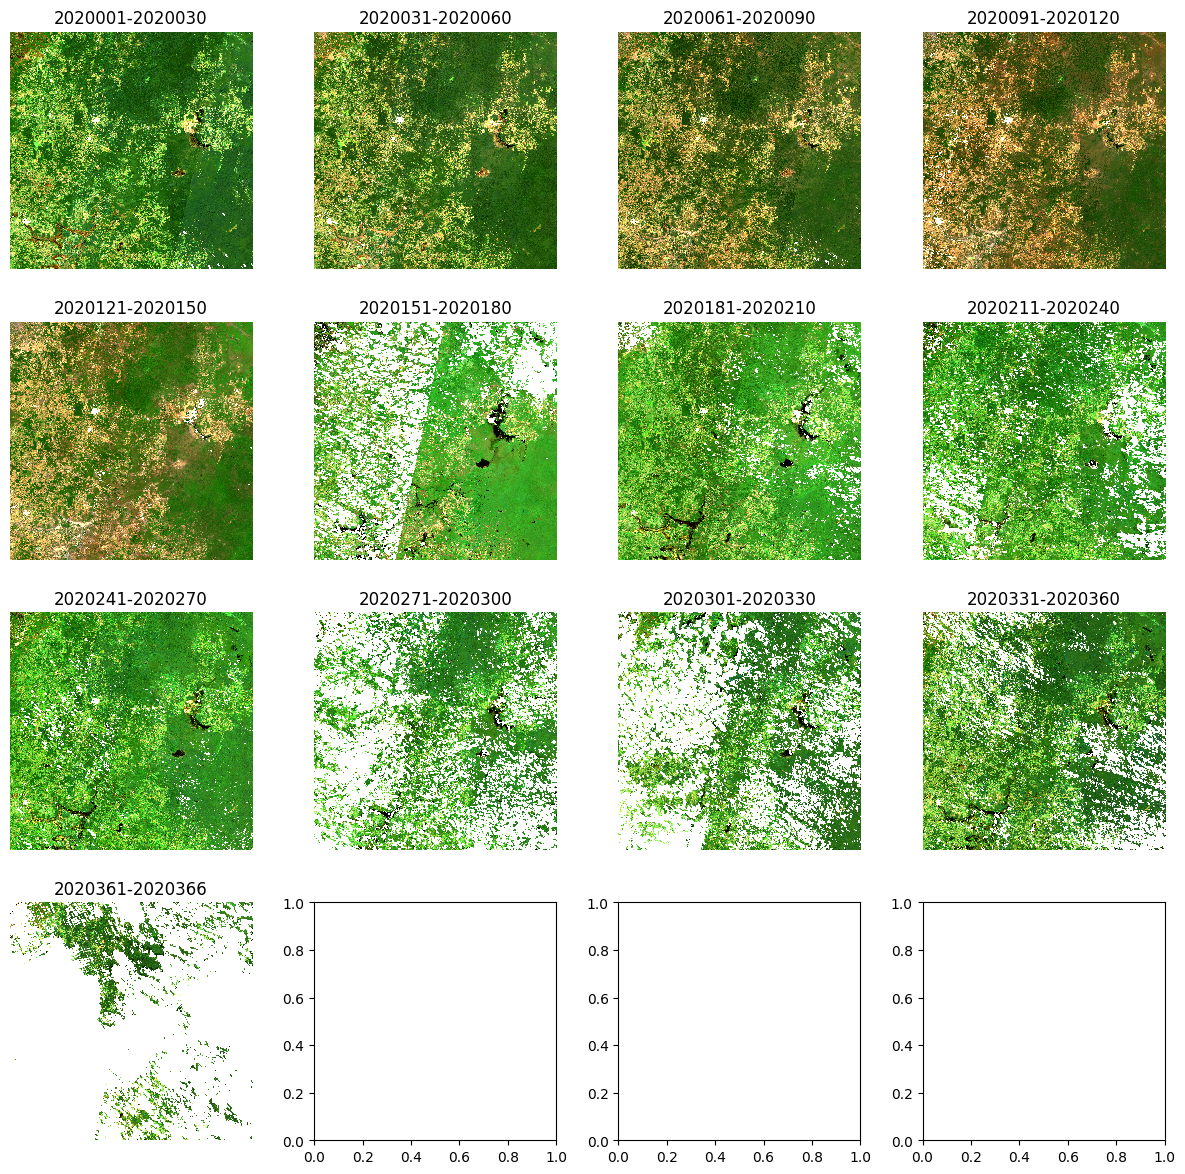

In [19]:
# Plotting takes a while
fig, ax = plt.subplots(4, 4) ## change if needed
fig.set_size_inches(12, 12)
ax_flat = ax.flatten()

for i, (label, sub_da) in enumerate(rgb.groupby('time')):
     print(f'plotting {label}')
     ax = ax_flat[i]
     sub_da.squeeze().plot.imshow(ax=ax, robust=True)
     ax.set_title(f'{label}')
     ax.set_axis_off()
fig.tight_layout()
plt.show()

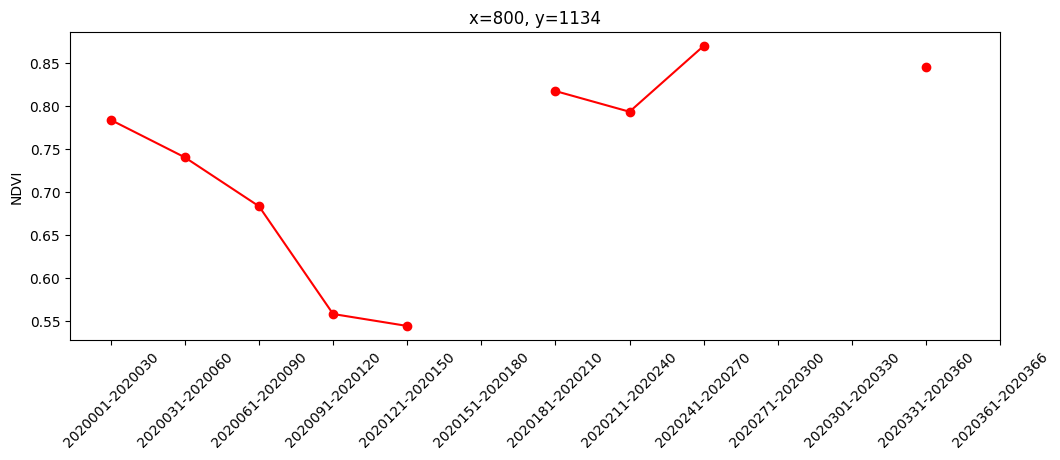

In [20]:
# Plot a simple time history of NDVI for a pixel

# Define pixel x and y index
pixel_xidx = 800
pixel_yidx = 1134

# Plot pixel ndvi
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 4)

# Since the 'time' coordinates in the da are NOT in datetime format, hack to get xlabels
pixel_ndvi = ndvi.squeeze().isel(x=pixel_xidx, y=pixel_yidx).values
x_positions = np.arange(0, len(pixel_ndvi))

ax.plot(x_positions, pixel_ndvi, 'ro-')
ax.set_ylabel('NDVI')
ax.set_title(f"x={pixel_xidx}, y={pixel_yidx}")
plt.xticks(x_positions, labels=ndvi['time'].values, rotation=45)
plt.show()